In [1]:
import warnings
import scanpy as sc
import squidpy as sq
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
#import scanorama
import json
import os

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

### Глобальные переменные

In [2]:
qc_palette = sns.color_palette(['red', 'gray'])

In [3]:
layer_palette = {'Empty spots': '#1f77b4',
                 'WM': '#bcbd22',
                 'L1': '#ff7f0e',
                 'L6': '#e377c2',
                 'L2': '#2ca02c',
                 'L3': '#d62728',
                 'L4': '#9467bd',
                 'L5': '#8c564b',
                 'L6a': '#ffc0cb',
                 'L6b': '#fa9284'}

# Подгрузим файлы

In [4]:
# Define paths and get sample_ids
file_list = os.listdir('../data/raw_spatial_data/macaque/')
file_list

['macaque_0701', 'macaque_0703', 'macaque_0704', 'macaque_nb0904']

In [5]:
file = 'macaque_0701'

In [6]:
# аннотация слоёв
ann = pd.read_csv('../data/clusters/' + file + '.csv', index_col=0)
ann.columns = ['label']
ann.head()

label
Barcode                 
AAACAAGTATCTCCCA-1    L2
AAACACCAATAACTGC-1   L6a
AAACAGCTTTCAGAAG-1    L5
AAACAGGGTCTATATT-1   L6a
AAACATTTCCCGGATT-1    L1

In [7]:
# каунты секвенирования
adata = sc.read_visium('../data/raw_spatial_data/macaque/'+ file)
adata.var_names_make_unique()
adata.obs['label'] = ann.label
adata.obs['sample_id'] = file

reading ..\data\raw_spatial_data\macaque\macaque_0701\filtered_feature_bc_matrix.h5
 (0:00:00)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# adata

## Посчитаем метрики

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
adata.var['hb'] = adata.var_names.str.contains(("^HB[AB]"))
adata.var['ribo'] = adata.var_names.str.contains(("^RP[LS]"))

sc.pp.calculate_qc_metrics(
    adata, qc_vars=['mt','hb','ribo'],
    percent_top=None, log1p=False, inplace=True)

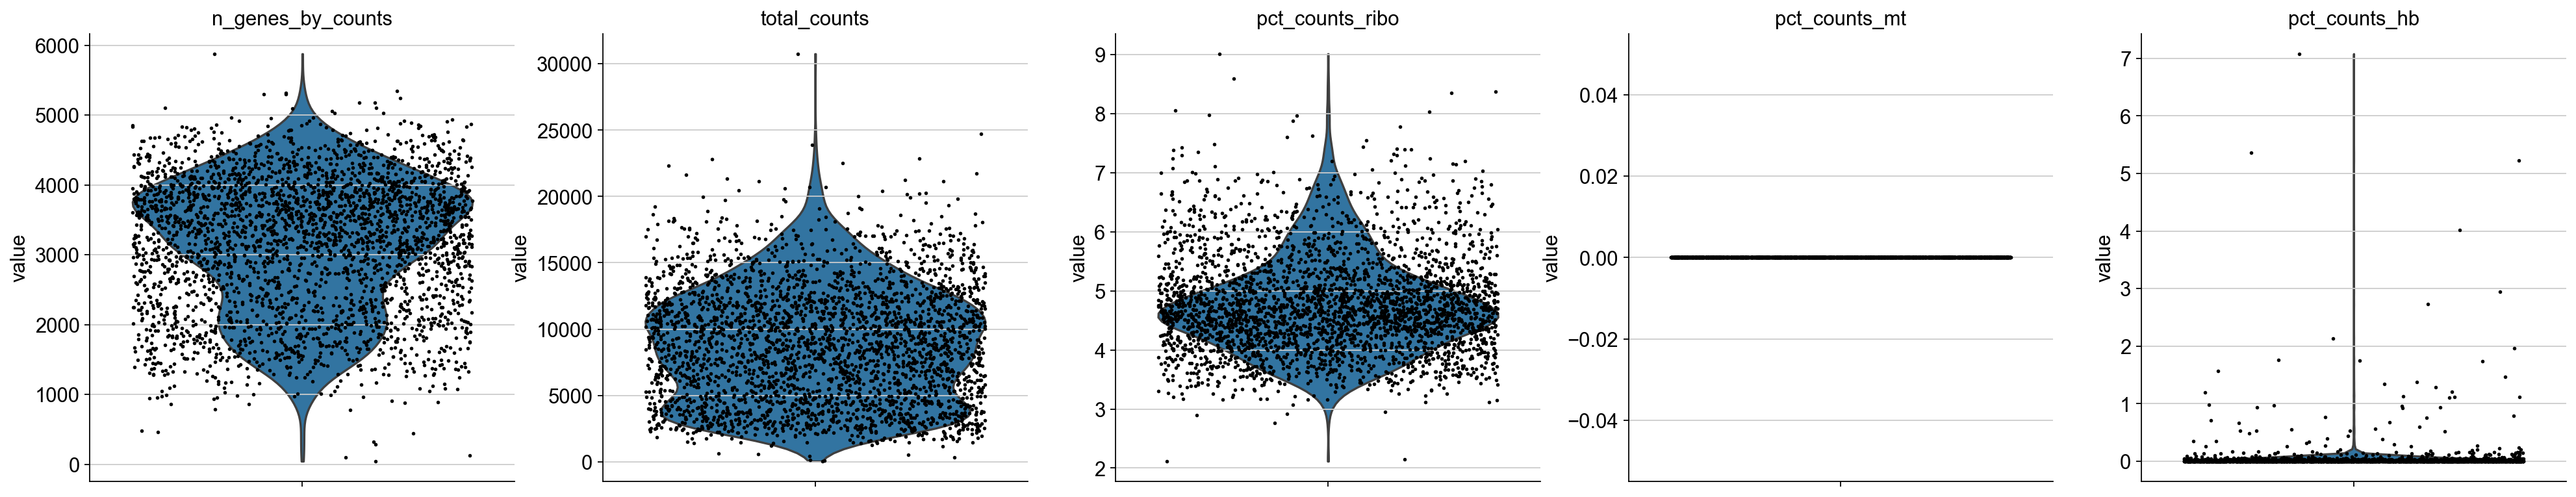

In [9]:
sc.pl.violin(adata,
             keys = ['n_genes_by_counts', 'total_counts','pct_counts_ribo', 'pct_counts_mt', 'pct_counts_hb'],
             jitter=0.4, rotation= 45, multi_panel=True, size=2.5)

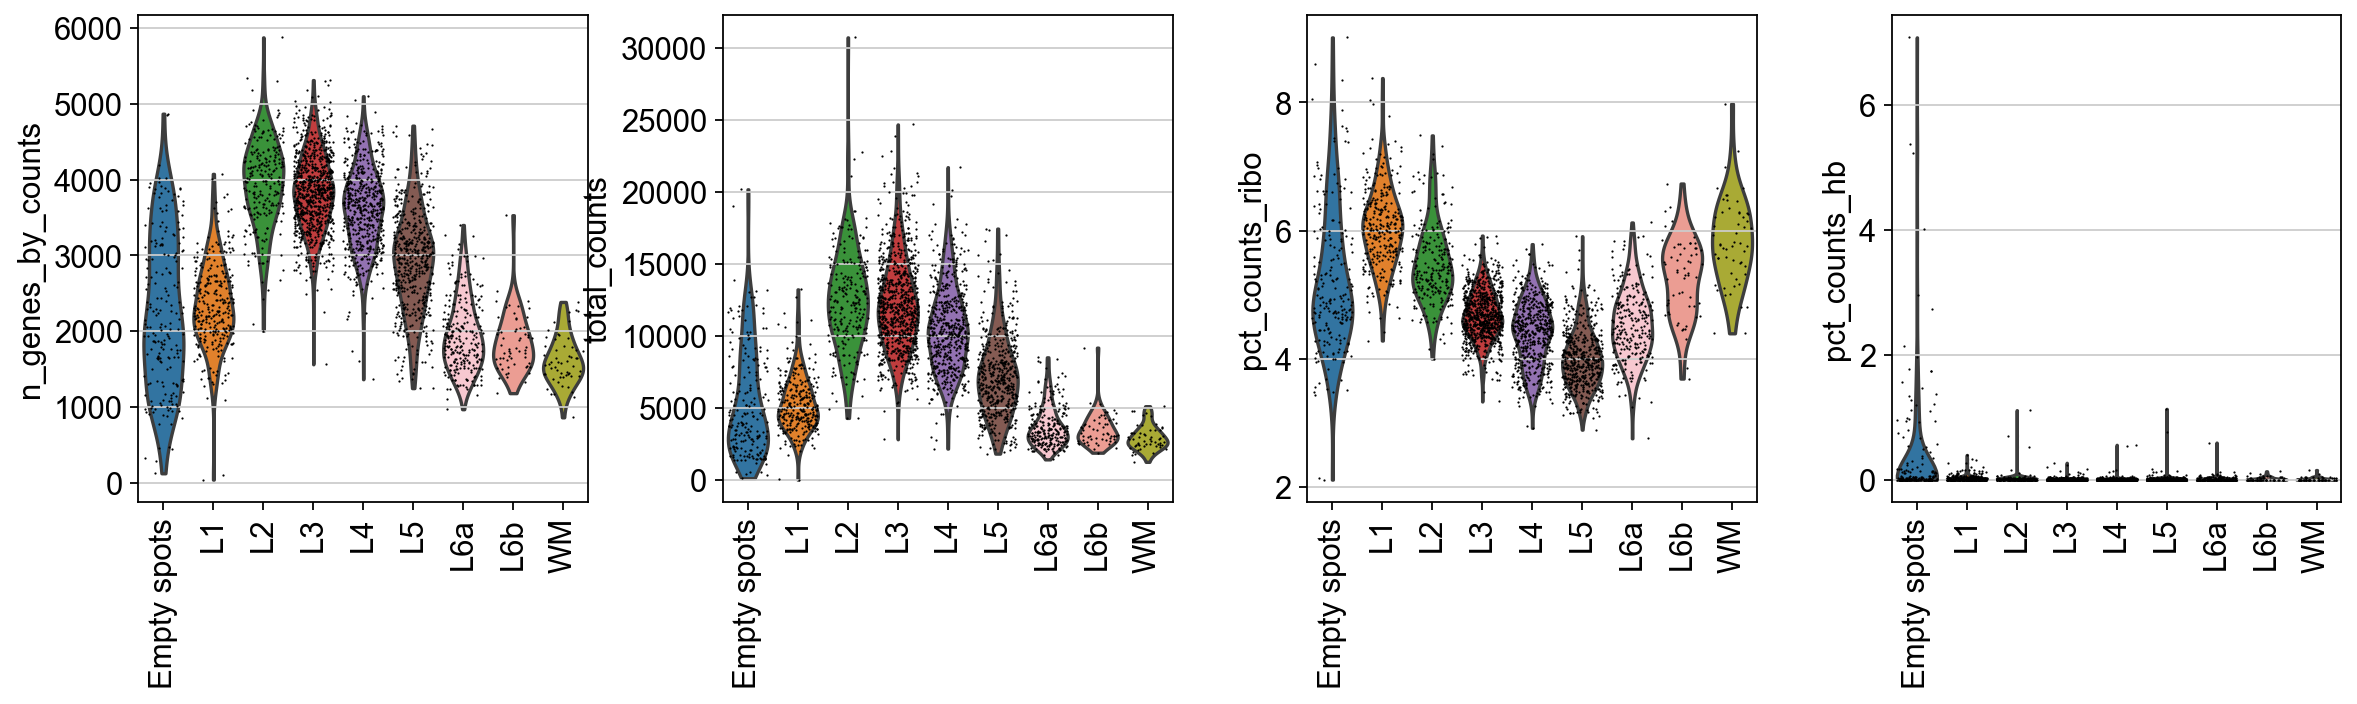

In [10]:
sc.pl.violin(adata,
             keys = ['n_genes_by_counts', 'total_counts','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'label', rotation= 90, palette=layer_palette)

Видим, что число каунтов и задетектированых генов занижено у `L1`, `L6` и `WM` слоёв. Поэтому хотелось бы быть с ними аккуратнее. Информации по митохондриальным генам нету, будем ориентироваться на рибосомные

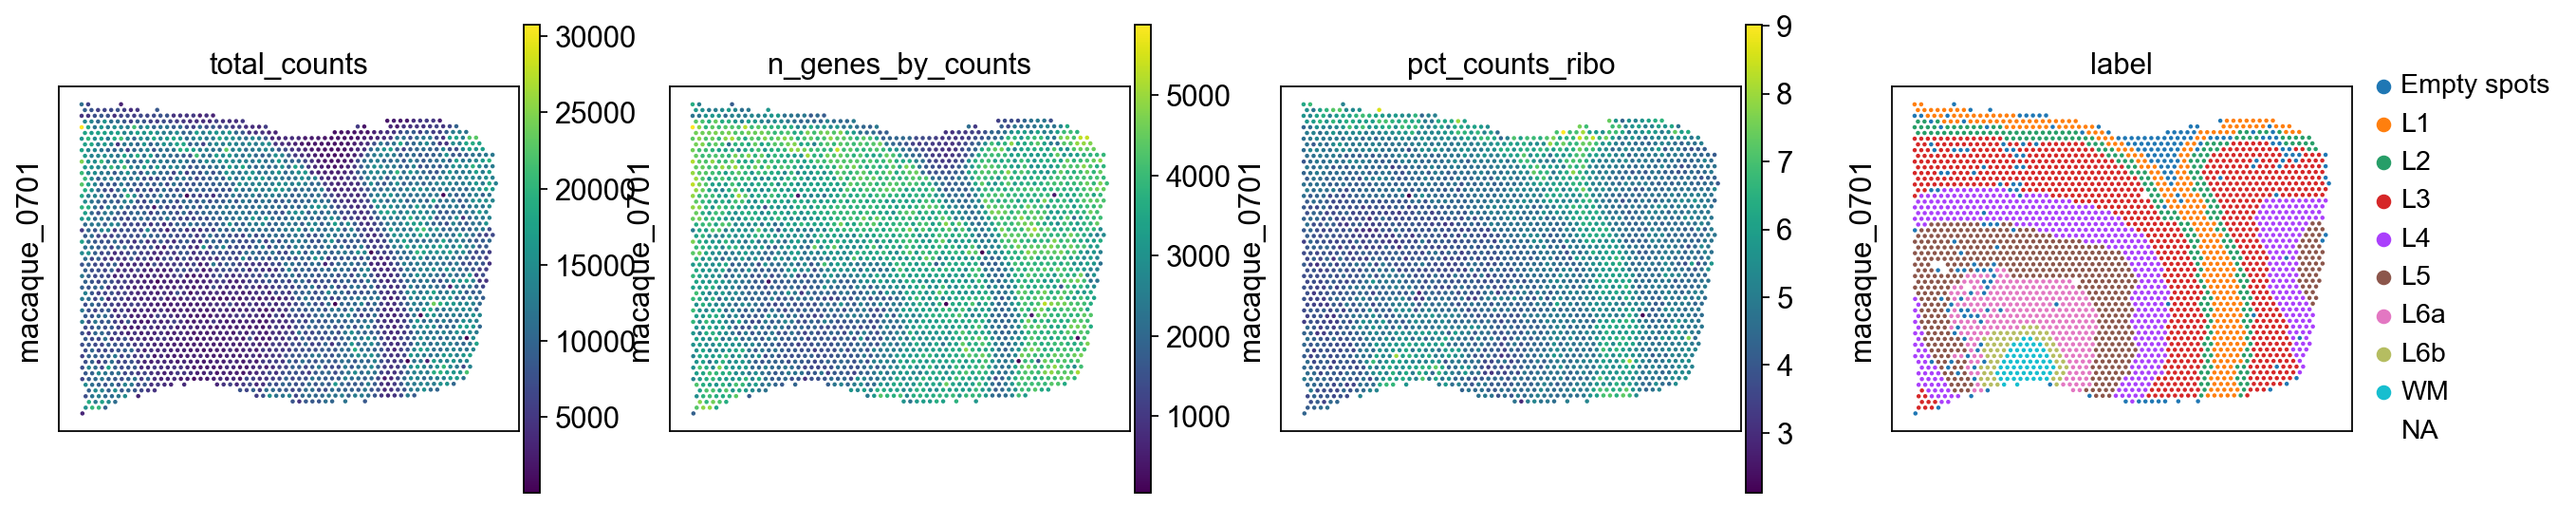

In [11]:
sq.pl.spatial_scatter(adata,
                      color = ['total_counts', 'n_genes_by_counts','pct_counts_ribo', 'label'],
                      ncols=4, img=False, axis_label=['', file])

### Libriary size

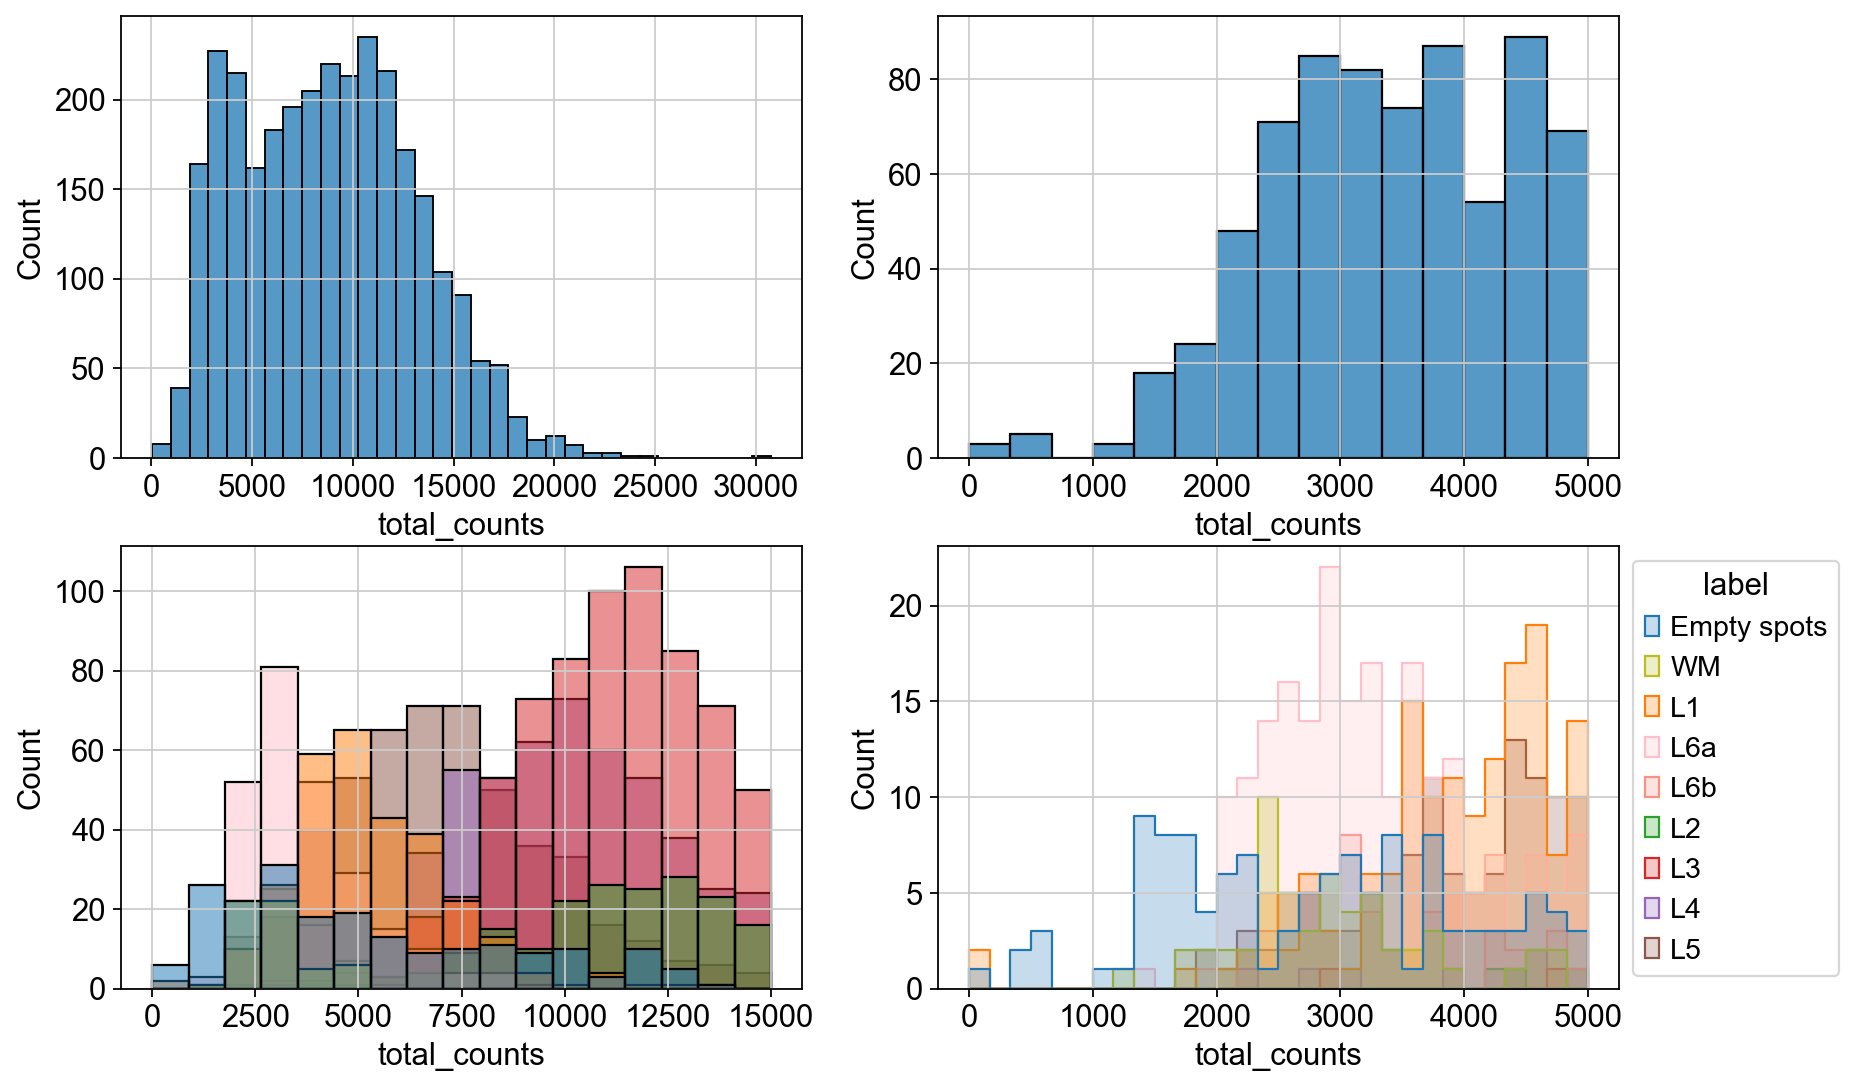

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
hue_order = ['Empty spots', 'WM', 'L1', 'L6a', 'L6b', 'L2', 'L3', 'L4', 'L5']

sns.histplot(adata.obs, x='total_counts', ax=axs[0][0])
sns.histplot(adata.obs, x='total_counts', binrange=[0, 15000], hue='label', hue_order=hue_order, ax=axs[1][0], legend=False, palette=layer_palette)
#sns.move_legend(axs[1][0], "upper left", bbox_to_anchor=(1, 1))
sns.histplot(adata.obs, x='total_counts', binrange=[0, 5000], ax=axs[0][1])
sns.histplot(adata.obs, x='total_counts', binrange=[0, 5000], bins=30, hue='label',fill=True, element="step", hue_order=hue_order, ax=axs[1][1], palette=layer_palette)
sns.move_legend(axs[1][1], "upper left", bbox_to_anchor=(1, 1))

Выберем порог по `total counts = 2000`. Поставим порог для `L6` и для всех остальных по отдельности

In [13]:
adata.obs['qc_lib_size'] = ((adata.obs['total_counts'] > 2000)).astype('string')
#adata.obs['qc_lib_size'].replace({True: 'TRUE', False: 'FALSE'}, inplace=True)

vc = adata.obs.groupby('qc_lib_size')['label'].value_counts()
print(f"число образцов не прошедших порог N={adata.obs['qc_lib_size'].value_counts()['False']}\n")
print(vc[vc > 0]['False'])

число образцов не прошедших порог N=54

label
Empty spots    37
L6a             6
WM              5
L1              3
L5              2
L6b             1
Name: label, dtype: int64


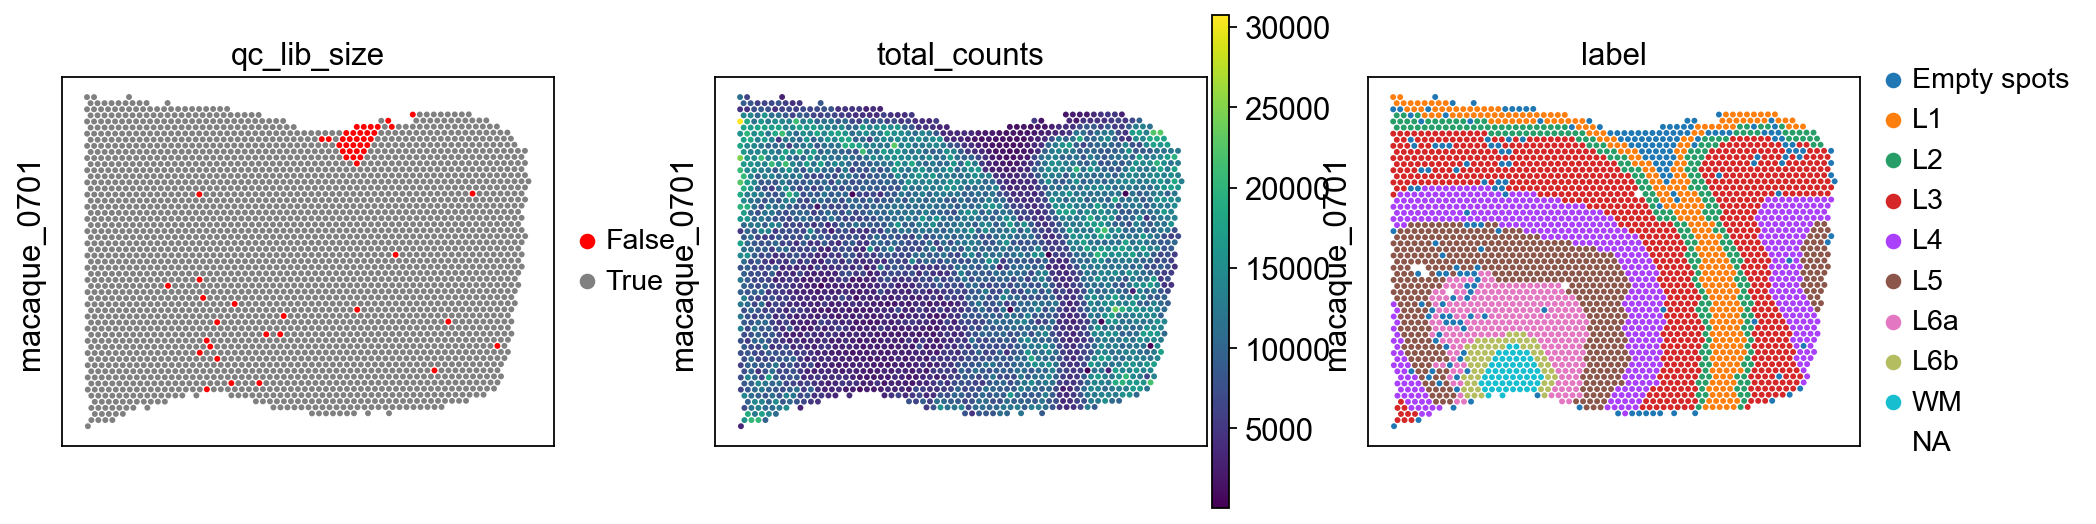

In [14]:
with qc_palette:
    sq.pl.spatial_scatter(adata, color=['qc_lib_size', 'total_counts', 'label'], img=False, axis_label=['', file], size=1.3)

### Number of expressed features

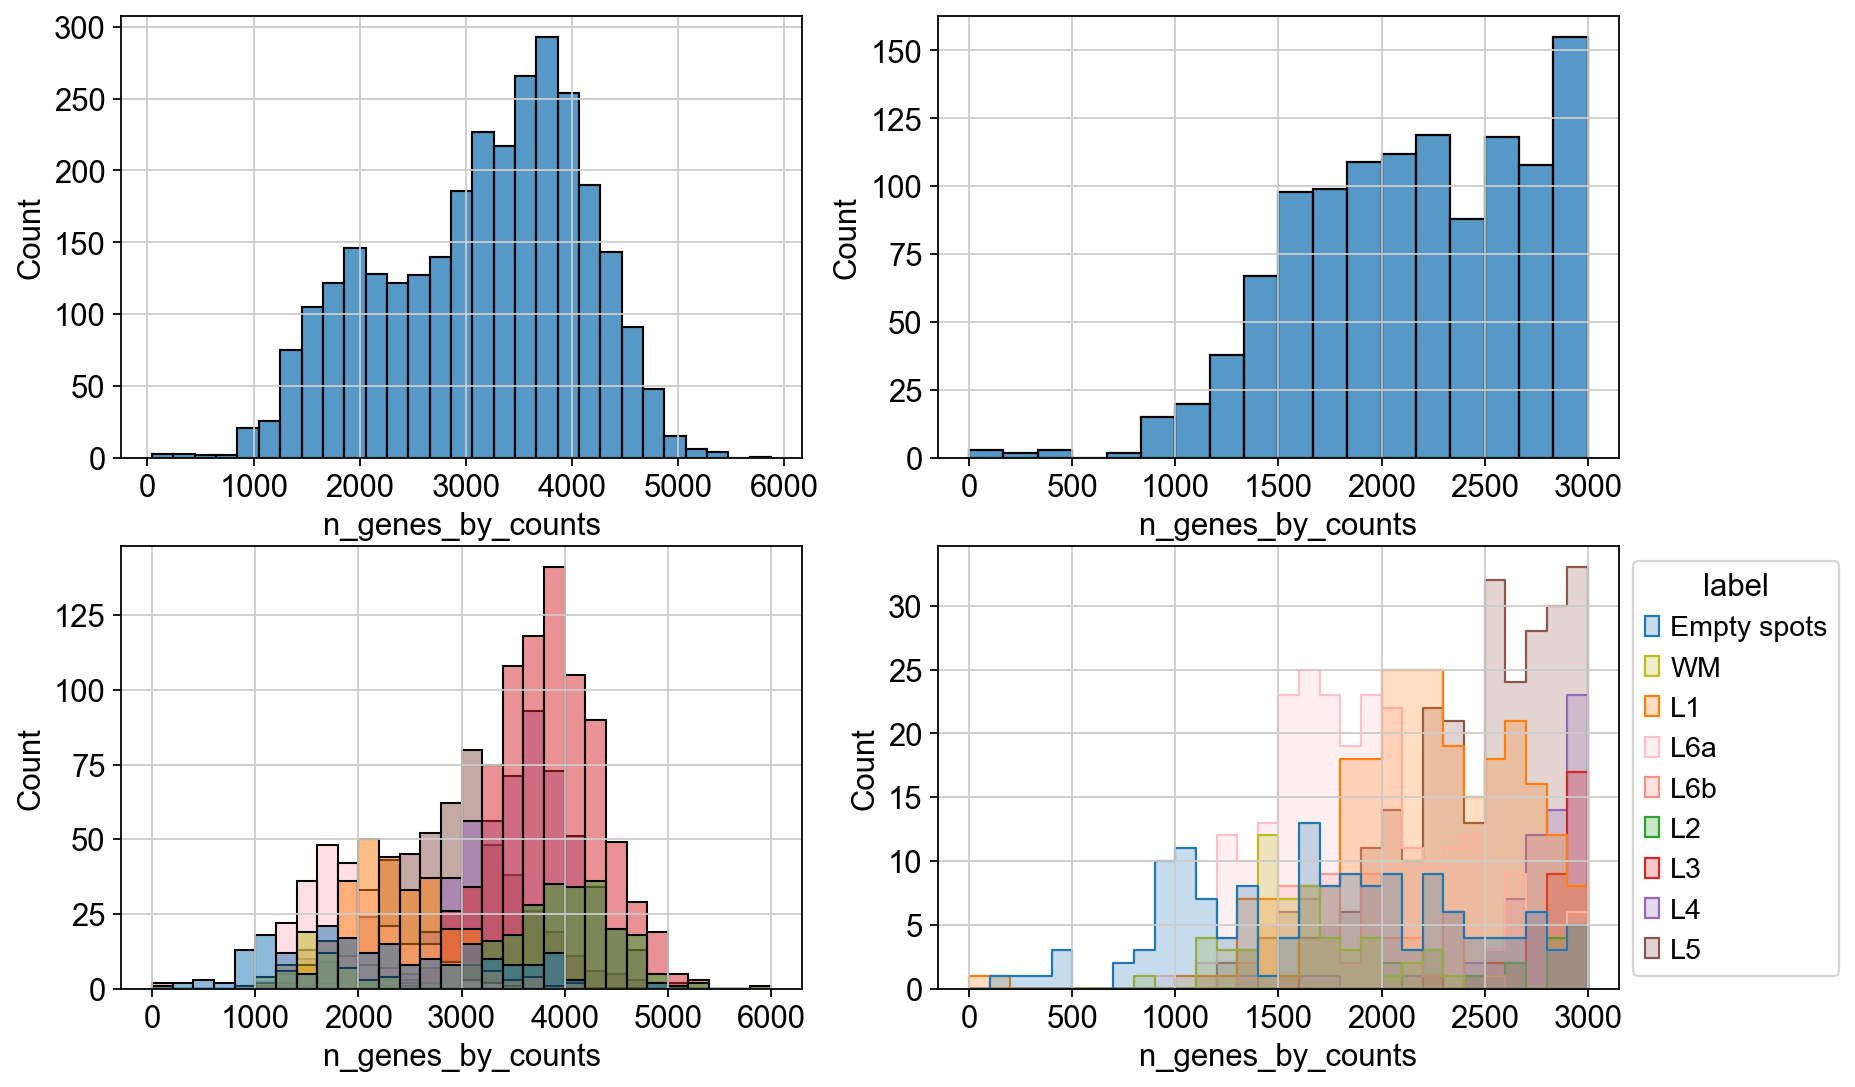

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
hue_order = ['Empty spots', 'WM', 'L1', 'L6a', 'L6b', 'L2', 'L3', 'L4', 'L5']

sns.histplot(adata.obs, x='n_genes_by_counts', ax=axs[0][0])
sns.histplot(adata.obs, x='n_genes_by_counts', binrange=[0, 6000], hue='label', hue_order=hue_order, ax=axs[1][0], legend=False, palette=layer_palette)
#sns.move_legend(axs[1][0], "upper left", bbox_to_anchor=(1, 1))
sns.histplot(adata.obs, x='n_genes_by_counts', binrange=[0, 3000], ax=axs[0][1])
sns.histplot(adata.obs, x='n_genes_by_counts', binrange=[0, 3000], bins=30, hue='label',fill=True, element="step", hue_order=hue_order, ax=axs[1][1], palette=layer_palette)
sns.move_legend(axs[1][1], "upper left", bbox_to_anchor=(1, 1))

Выберем порог по `total n_genes_by_counts = 1000`. Поставим порог для `WM` и для всех остальных по отдельности

In [16]:
adata.obs['qc_n_genes'] = ((adata.obs['n_genes_by_counts'] > 1200)).astype('string')
#adata.obs['qc_n_genes'].replace({True: 'True', False: 'False'}, inplace=True)
vc = adata.obs.groupby('qc_n_genes')['label'].value_counts()
print(f"число образцов не прошедших порог N={adata.obs['qc_n_genes'].value_counts()['False']}\n")
print(vc[vc > 0]['False'])

число образцов не прошедших порог N=52

label
Empty spots    39
WM              5
L1              4
L6a             3
L6b             1
Name: label, dtype: int64


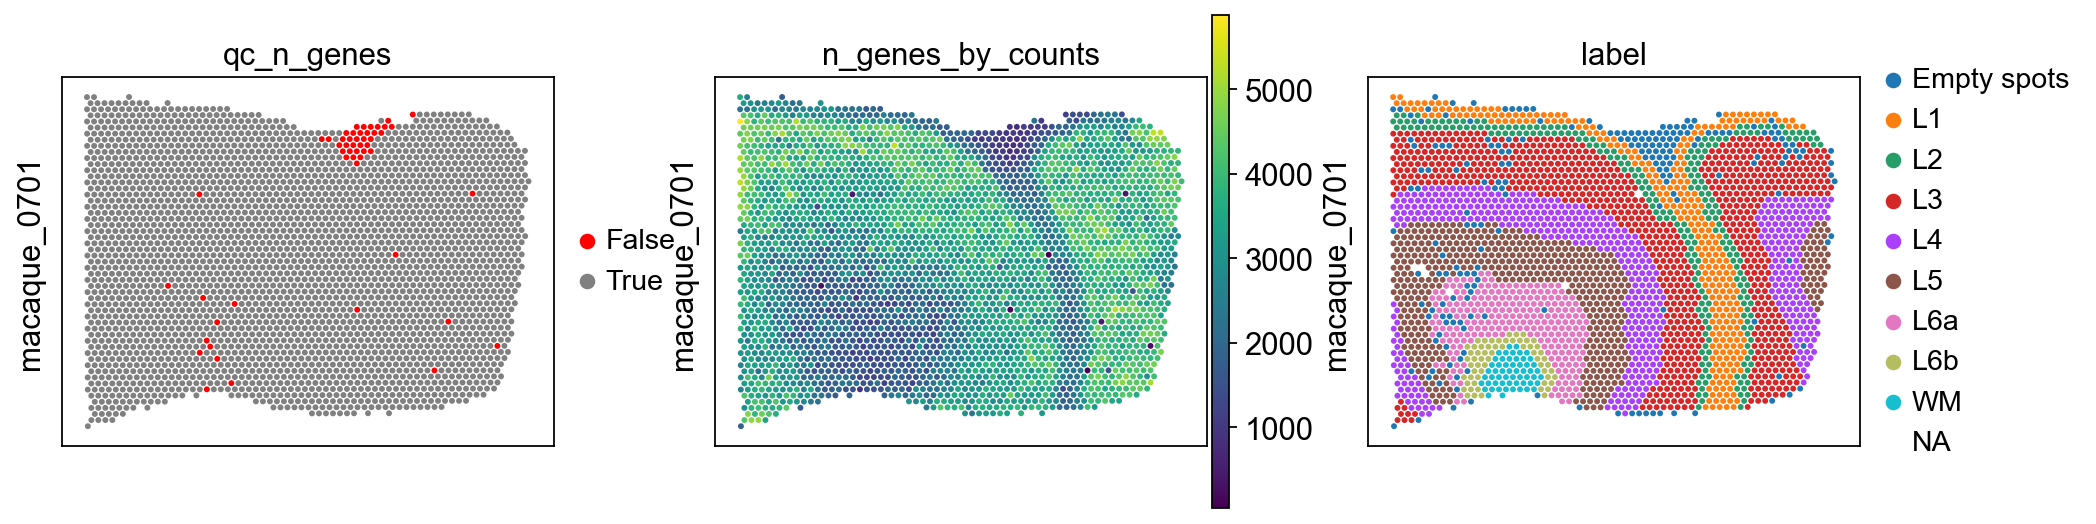

In [17]:
with qc_palette:
    sq.pl.spatial_scatter(adata, color=['qc_n_genes', 'n_genes_by_counts', 'label'], img=False, axis_label=['', file], size=1.3)

### Proportion of ribosomal reads

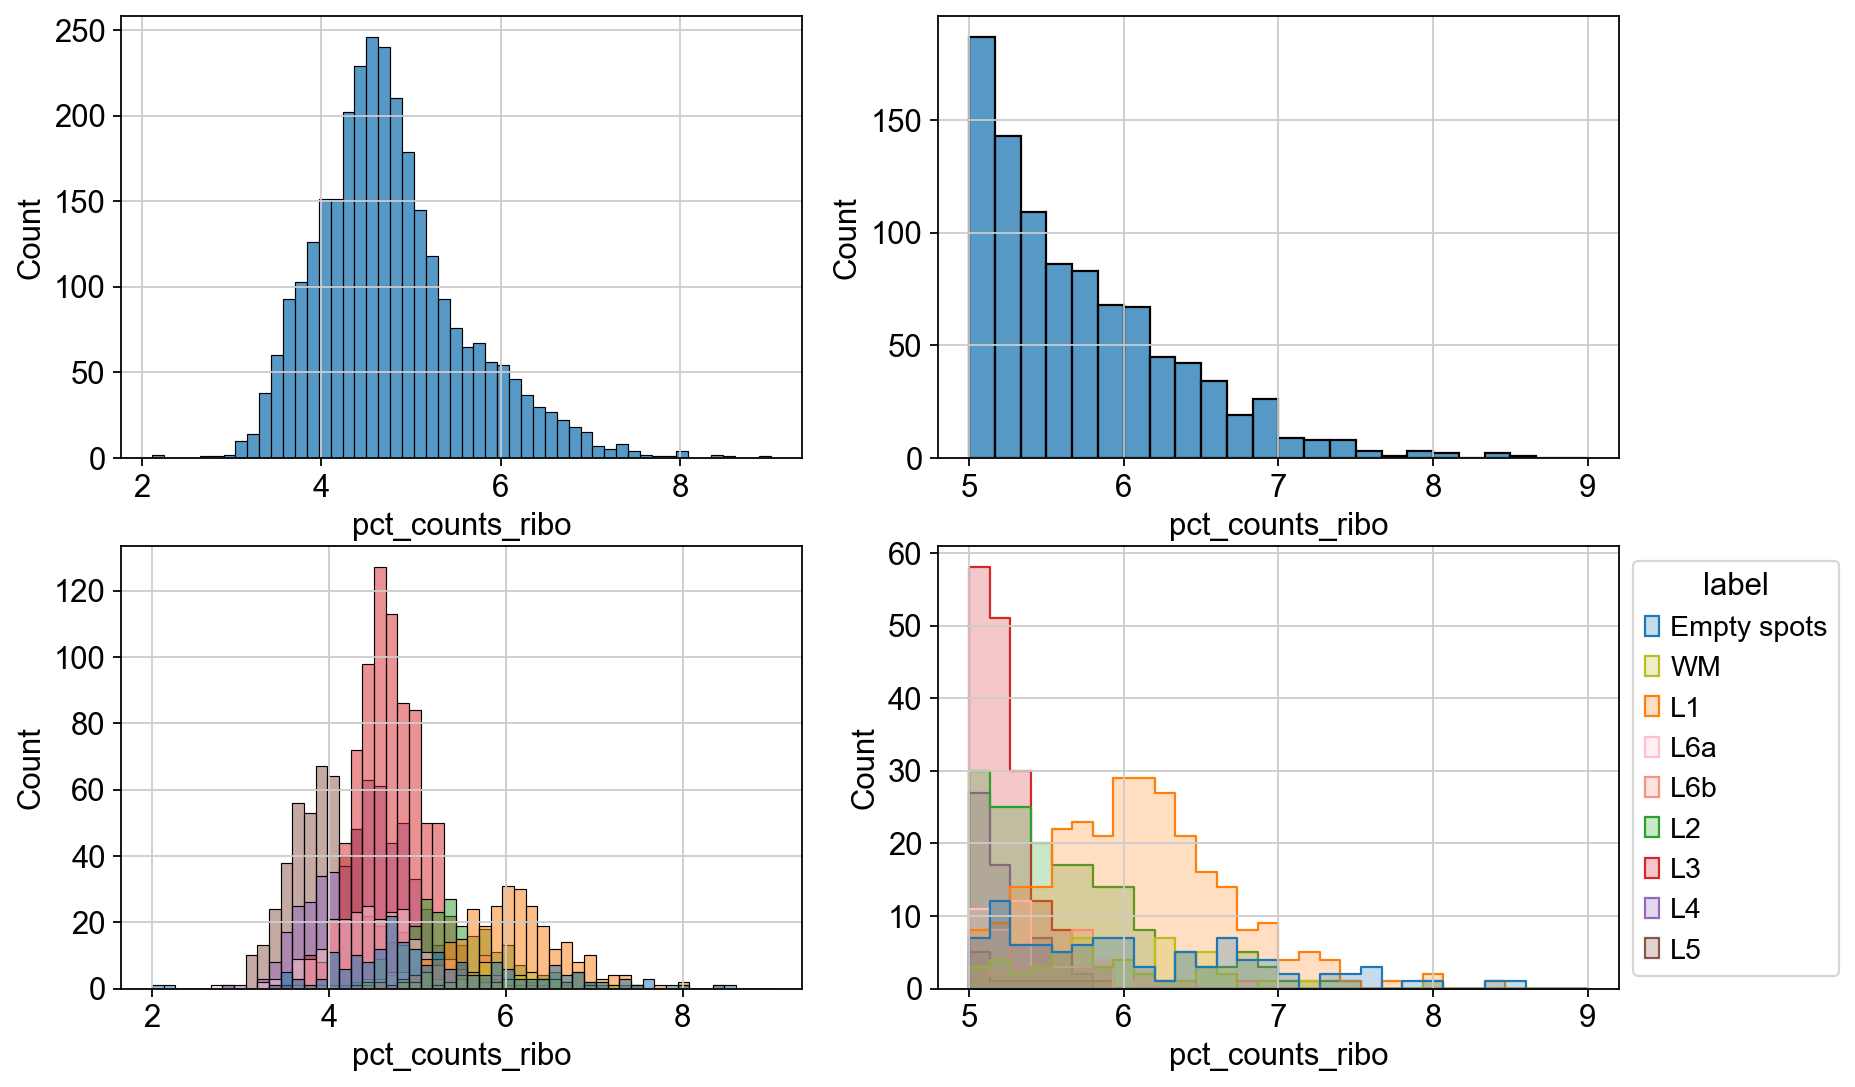

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
hue_order = ['Empty spots', 'WM', 'L1', 'L6a', 'L6b', 'L2', 'L3', 'L4', 'L5']

sns.histplot(adata.obs, x='pct_counts_ribo', ax=axs[0][0])
sns.histplot(adata.obs, x='pct_counts_ribo', binrange=[2, 9], hue='label', hue_order=hue_order, ax=axs[1][0], legend=False, palette=layer_palette)
#sns.move_legend(axs[1][0], "upper left", bbox_to_anchor=(1, 1))
sns.histplot(adata.obs, x='pct_counts_ribo', binrange=[5, 9], ax=axs[0][1])
sns.histplot(adata.obs, x='pct_counts_ribo', binrange=[5, 9], hue='label', bins=30, hue_order=hue_order, ax=axs[1][1], fill=True, element="step", palette=layer_palette)
sns.move_legend(axs[1][1], "upper left", bbox_to_anchor=(1, 1))

Поставим для всех не из `L1` порог `pct_counts_mt = 25`, а для `L1` порог `pct_counts_mt = 32`.

In [19]:
adata.obs['qc_ribo'] = ((adata.obs['pct_counts_ribo'] <= 7.5)).astype('string')
#adata.obs['qc_mt'].replace({True: 'TRUE', False: 'FALSE'}, inplace=True)
vc = adata.obs.groupby('qc_ribo')['label'].value_counts()
print(f"число образцов не прошедших порог N={adata.obs['qc_ribo'].value_counts()['False']}\n")
print(vc[vc > 0]['False'])

число образцов не прошедших порог N=13

label
Empty spots    8
L1             4
WM             1
Name: label, dtype: int64


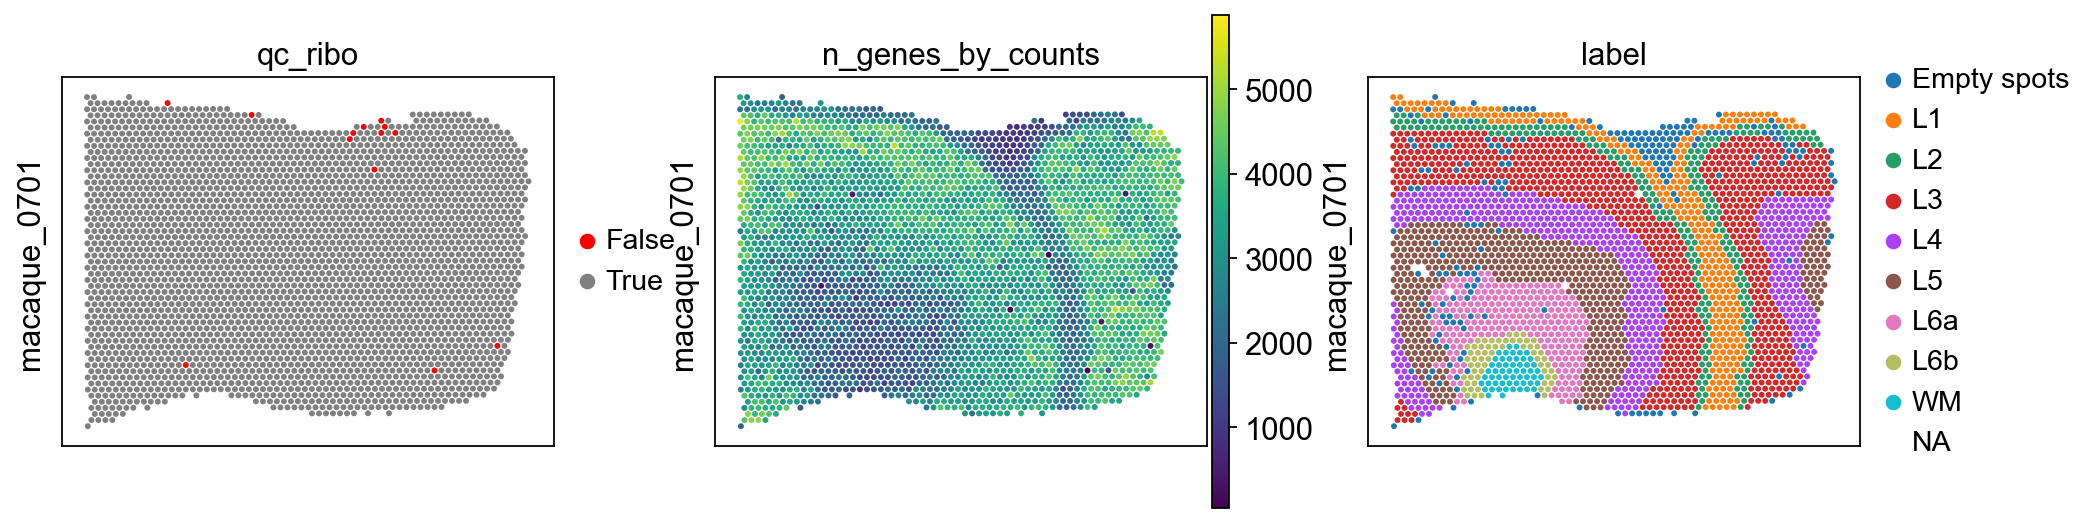

In [20]:
with qc_palette:
    sq.pl.spatial_scatter(adata, color=['qc_ribo', 'n_genes_by_counts', 'label'], img=False, axis_label=['', file], size=1.3)

Очень странный `L1` слой. Я бы сказал, что маловато митохондриальной экспрессии

## Combined

### QC spatial_scatter

In [21]:
d = {'True': True, 'False': False}
adata.obs['qc_lib_size'] = adata.obs['qc_lib_size'].astype(object).replace(d)
adata.obs['qc_n_genes'] = adata.obs['qc_n_genes'].astype(object).replace(d)
adata.obs['qc_ribo'] = adata.obs['qc_ribo'].astype(object).replace(d)

In [22]:
adata.obs['qc_good_spots'] = (adata.obs.qc_lib_size * adata.obs.qc_n_genes * adata.obs.qc_ribo).astype('string')
vc = adata.obs.groupby('qc_good_spots')['label'].value_counts()
print(f"число образцов не прошедших порог N={adata.obs['qc_good_spots'].value_counts()['False']}\n")
print(vc[vc > 0]['False'])

число образцов не прошедших порог N=63

label
Empty spots    41
L1              7
L6a             6
WM              6
L5              2
L6b             1
Name: label, dtype: int64


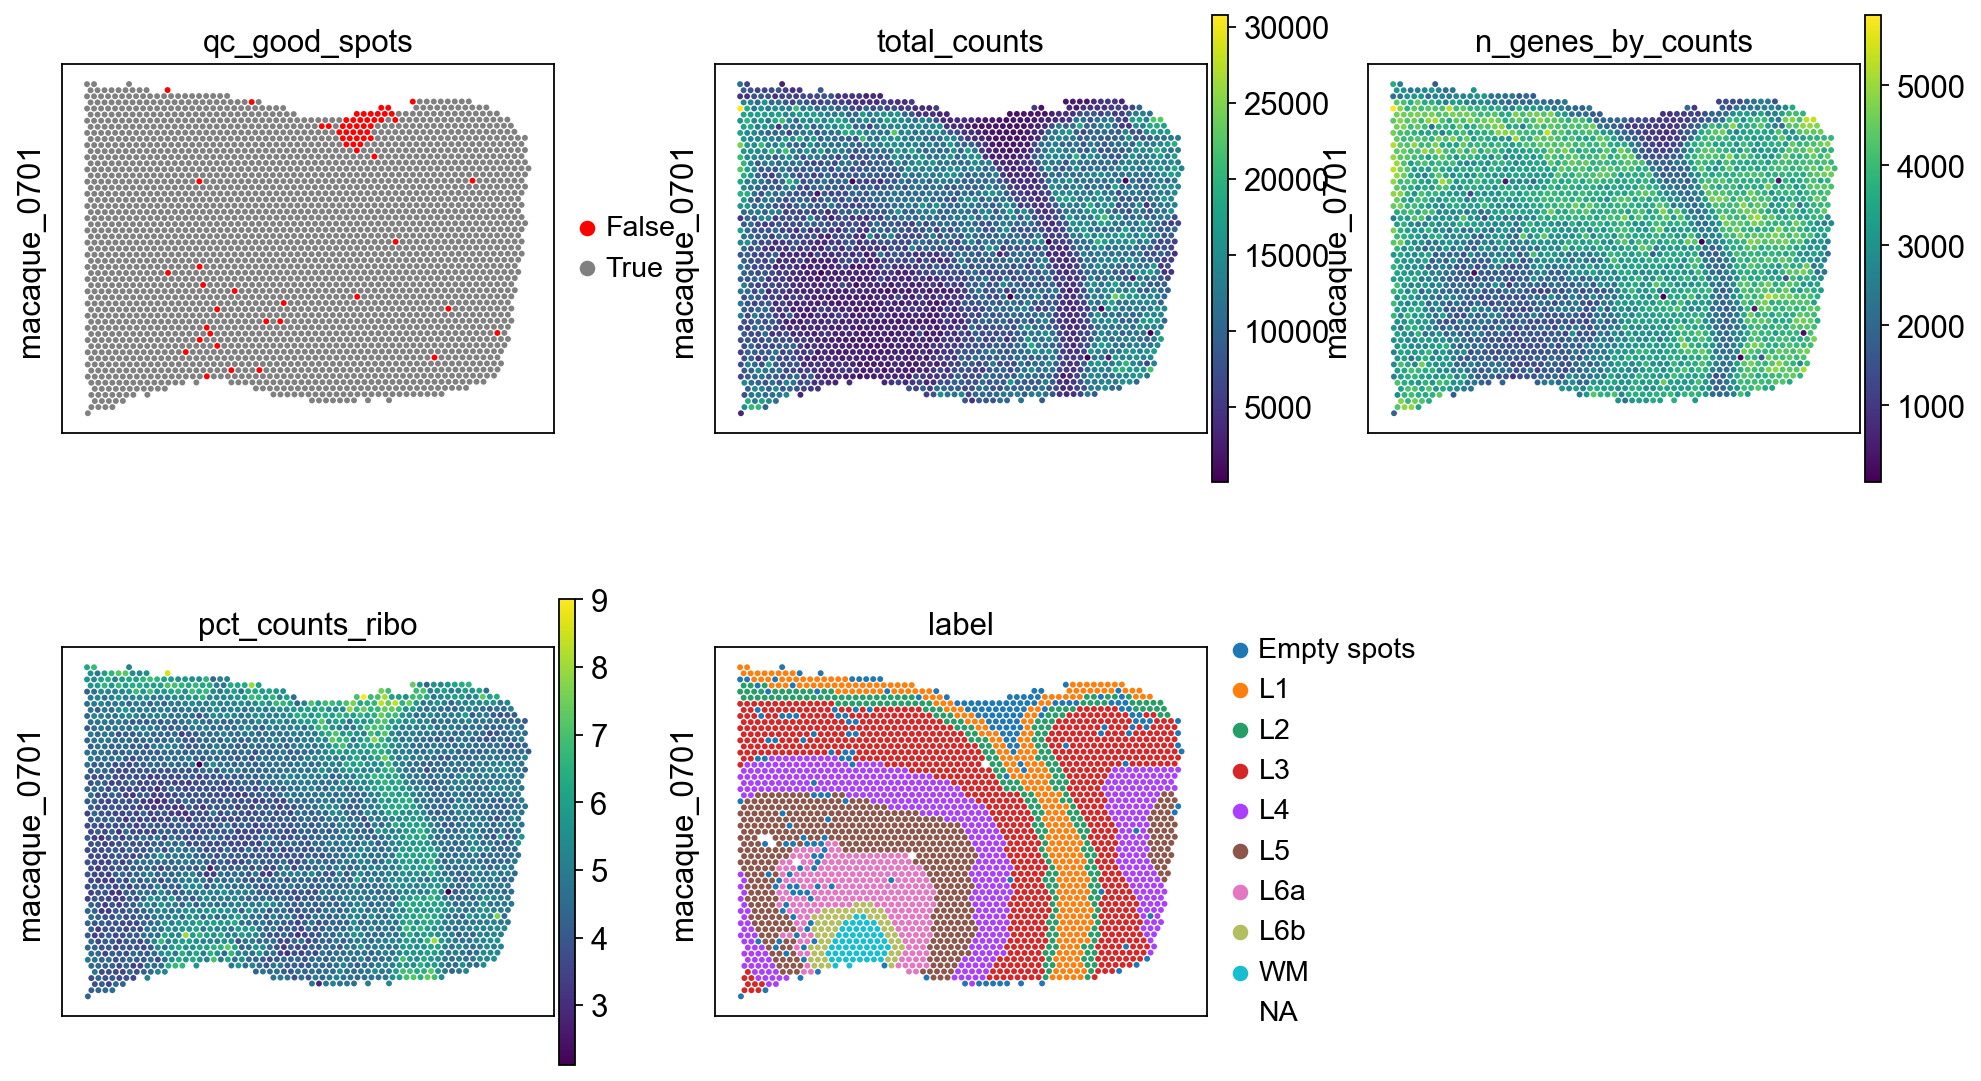

In [23]:
with qc_palette:
    sq.pl.spatial_scatter(adata, color=['qc_good_spots',  'total_counts', 'n_genes_by_counts', 'pct_counts_ribo', 'label'],
                          img=False, axis_label=['', file], size=1.3, ncols=3)

### QC scatter plots

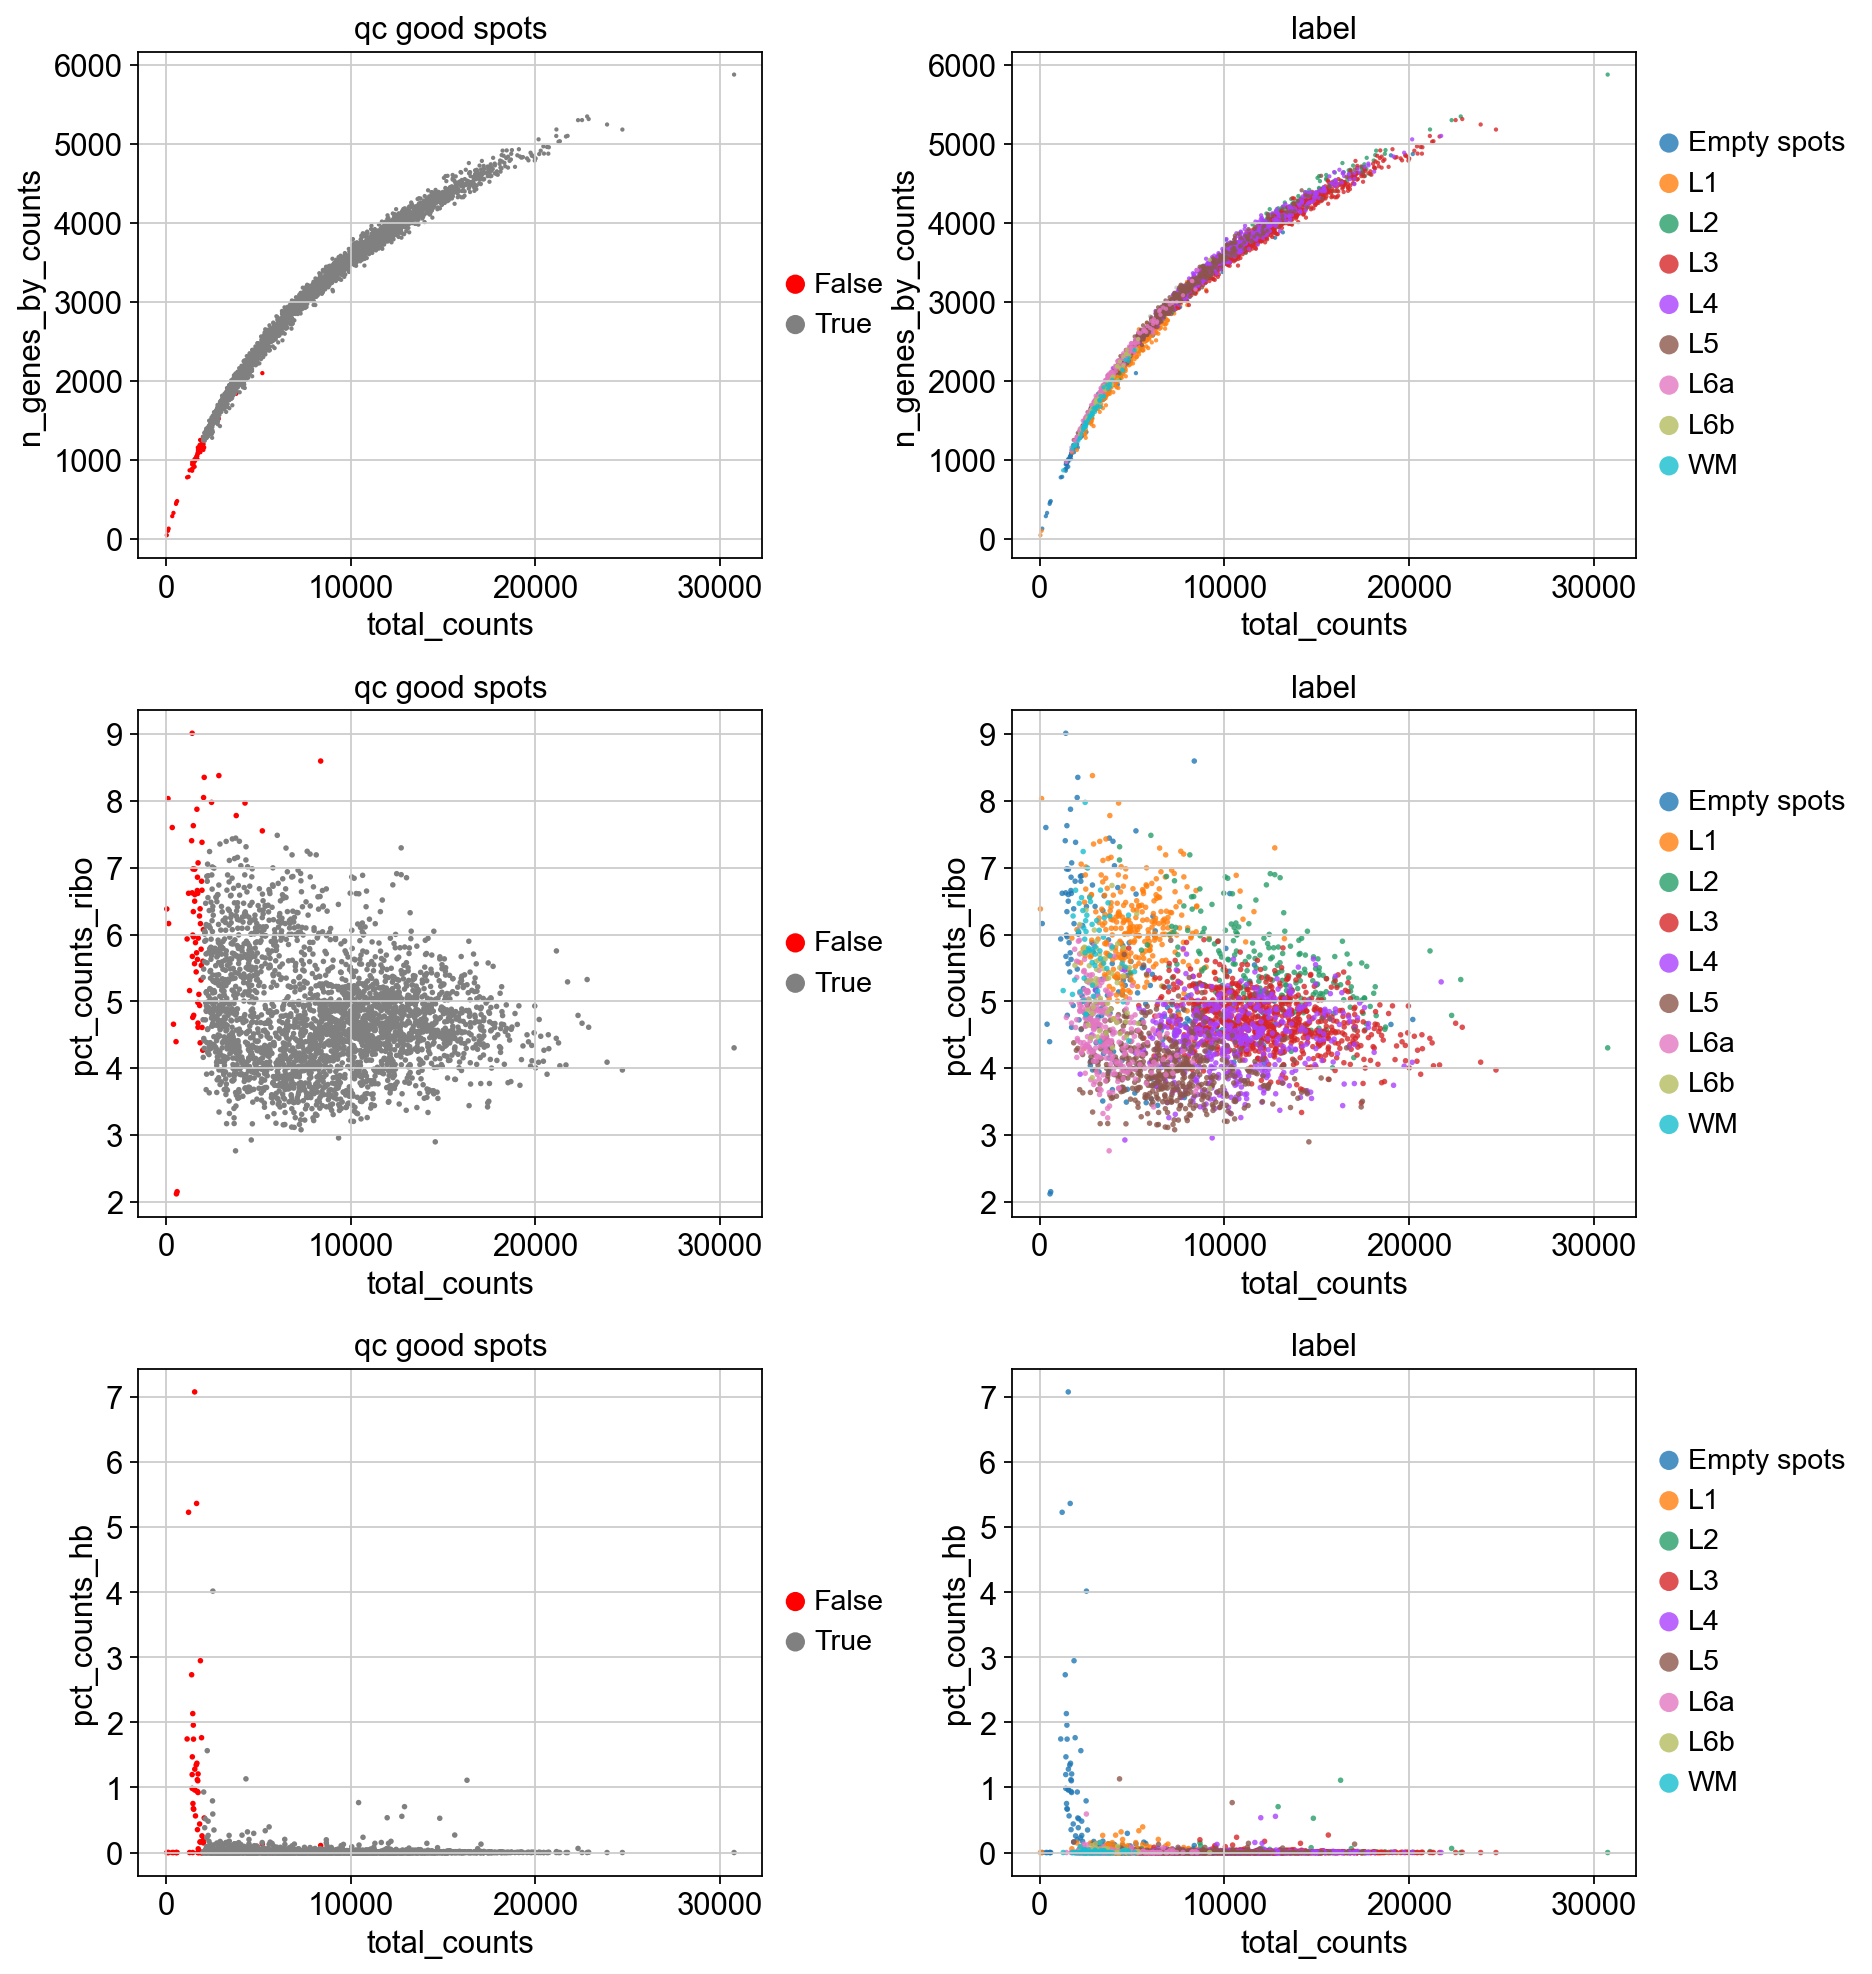

In [24]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15), gridspec_kw={'wspace': 0.4, 'hspace': 0.3})
alpha = 0.8


sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color="qc_good_spots", ax=ax[0][0], show=False, size=15)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color="label", ax=ax[0][1], show=False, alpha=alpha, size=15)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo', color="qc_good_spots", ax=ax[1][0], show=False, size=25)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo', color="label", ax=ax[1][1], show=False, alpha=alpha, size=25)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_hb', color="qc_good_spots", ax=ax[2][0], show=False, size=25)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_hb', color="label", ax=ax[2][1], show=False, alpha=alpha, size=25)

plt.show()

### Cохраним отфильтрованые споты (без пустых)

In [25]:
good_spots = adata.obs[(adata.obs.qc_good_spots == 'True') & (adata.obs.label != 'Empty spots')].index

In [26]:
adata_filtered = adata[good_spots].copy()

### PCA

In [27]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:31)


C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\aleks\anaconda3\envs\scanorama39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


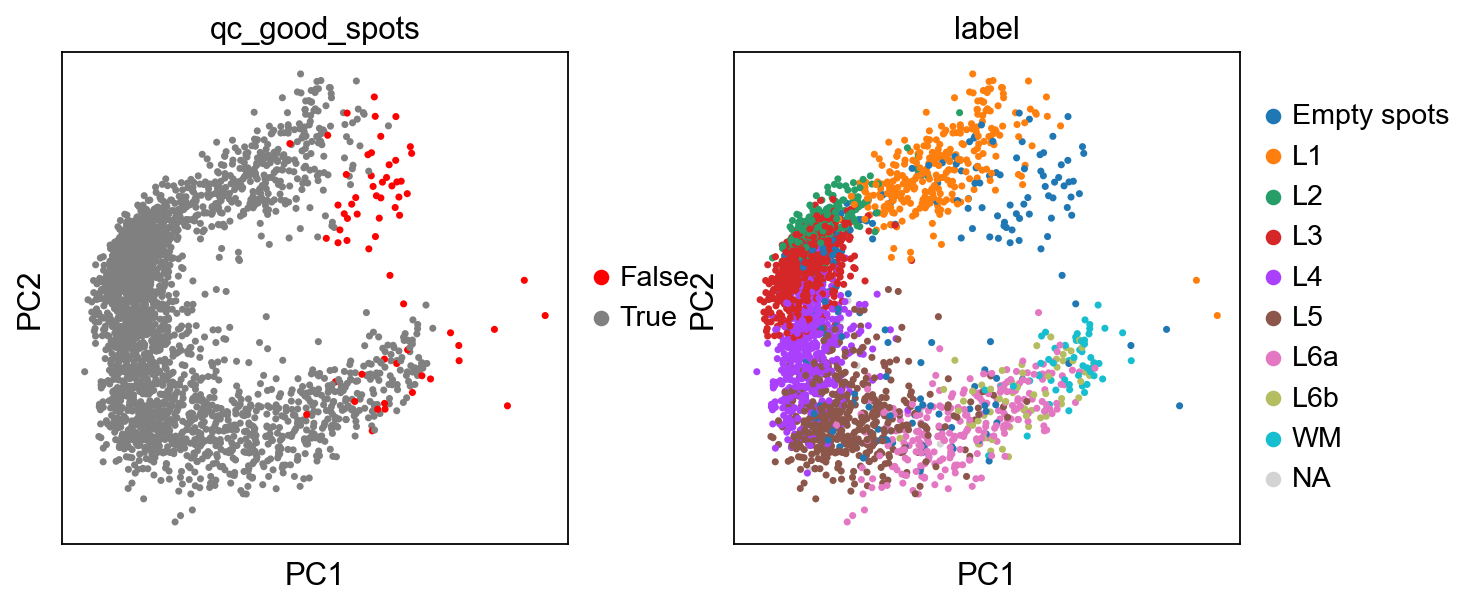

In [28]:
sc.pl.pca(adata, color=['qc_good_spots', 'label'])

Кажется вполне неплохо. Есть вопросы по пустым спотам в гуще классов. Мб они и не пустые совсем

## Сохраним в .h5ad

In [29]:
adata_filtered.obs.drop(['qc_lib_size','qc_n_genes', 'qc_good_spots', 'qc_ribo'], axis=1, inplace=True)

In [30]:
adata_filtered.obs.head()

in_tissue  array_row  array_col label     sample_id  \
AAACAAGTATCTCCCA-1          1         50        102    L2  macaque_0701   
AAACACCAATAACTGC-1          1         59         19   L6a  macaque_0701   
AAACAGCTTTCAGAAG-1          1         43          9    L5  macaque_0701   
AAACAGGGTCTATATT-1          1         47         13   L6a  macaque_0701   
AAACATTTCCCGGATT-1          1         61         97    L1  macaque_0701   

                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACAAGTATCTCCCA-1               4640       16462.0              0.0   
AAACACCAATAACTGC-1               2878        6475.0              0.0   
AAACAGCTTTCAGAAG-1               3113        7312.0              0.0   
AAACAGGGTCTATATT-1               1954        3633.0              0.0   
AAACATTTCCCGGATT-1               3063        7776.0              0.0   

                    pct_counts_mt  total_counts_hb  pct_counts_hb  \
AAACAAGTATCTCCCA-1            0.0              1.0       0.006075   
AAACACCAATAACTGC-1            0.0              0.0       0.000000   
AAACAGCTTTCAGAAG-1            0.0              2.0       0.027352   
AAACAGGGTCTATATT-1            0.0              0.0       0.000000   
AAACATTTCCCGGATT-1            0.0              3.0       0.038580   

                    total_counts_ribo  pct_counts_ribo  
AAACAAGTATCTCCCA-1              827.0         5.023691  
AAACACCAATAACTGC-1              292.0         4.509653  
AAACAGCTTTCAGAAG-1              300.0         4.102845  
AAACAGGGTCTATATT-1              176.0         4.844481  
AAACATTTCCCGGATT-1              449.0         5.774177

In [31]:
os.makedirs('../results/filtered_samples', exist_ok=True)
os.makedirs('../results/filtered_samples/macaque', exist_ok=True)
adata_filtered.write_h5ad(f'../results/filtered_samples/macaque/{file}.h5ad')